In [31]:
# Importing Modules

import cv2
from tqdm import tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

# PIL module is used to extract
# pixels of image and modify it
from PIL import Image

### Exploration

We provide two figures, one is `original.png`, another is `stego.png`. 

Can you distinguish the difference between them?

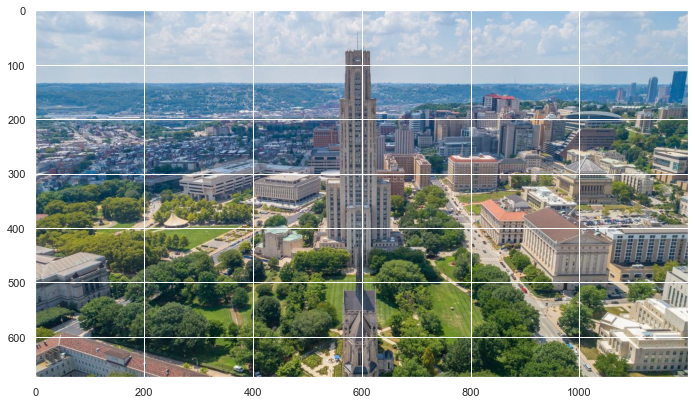

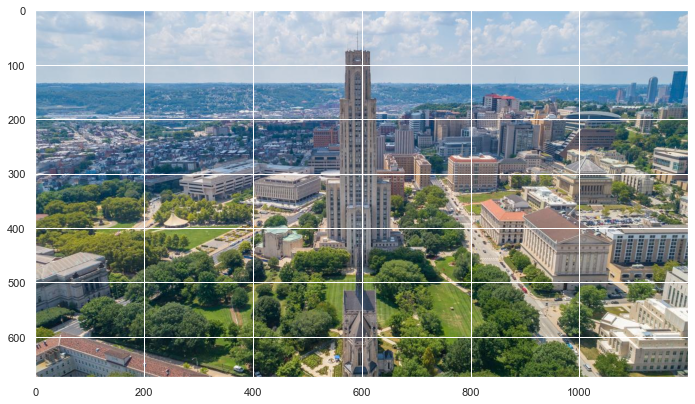

In [4]:
plt.imshow(plt.imread('original.png'))
plt.show()
plt.imshow(plt.imread('stego.png'))
plt.show()

It is hard to distingush the difference between the above two figures, but we have hidden secrete messages in the second figure `stego.png`. 
How can we extract the message from the figure?

In the next few cells, we wll gradually show the steps of decoding the message from the figures. 

### Decode

We first take few pixels from the figure and represent them as numbers

In [29]:
img_file = "original.png"
image = Image.open(img_file, 'r')
image_data = list(image.getdata())

print(image.format, image.size, image.mode)
# print the first three pixels' value
print(image_data[:3])
# print the `Red` binary value of the first pixel
print("{0:b}".format(image_data[0][0]))

PNG (1200, 675) RGBA
[(192, 209, 219, 255), (192, 209, 219, 255), (194, 208, 219, 255)]
11000000


As you can see above, the pixels are represented as values and each pixel has three values `R,G,B` or four values `R,G,B,A`, each contains 8 bits (`0` or `1`) information

If we just change the least significant bit of the color value of a pixel, it is hard for a human to identify the difference

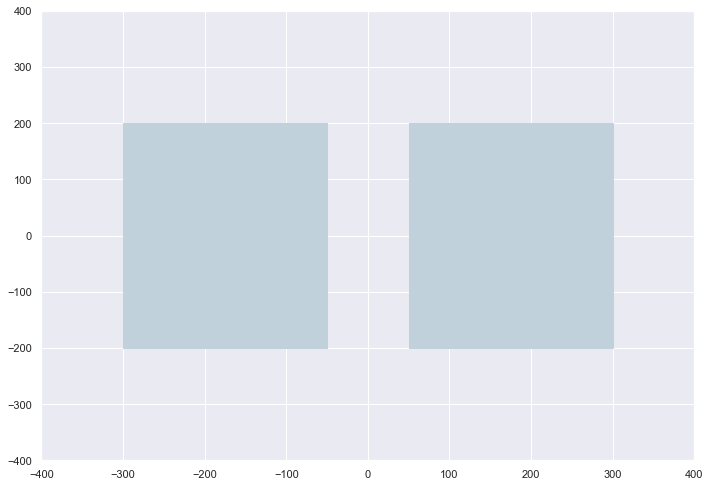

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111)
color1 = "#c0d1db"
color2 = "#c1d1db"
rect1 = matplotlib.patches.Rectangle((-300,-200), 250, 400, color=color1)
rect2 = matplotlib.patches.Rectangle((50, -200), 250, 400, color=color2)
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.xlim([-400, 400])
plt.ylim([-400, 400])
plt.show()

The above two rectangles show two colors that only different in there `Red` value, which are `192` and `193` respectively. 

It is hard to distinguish the difference between the two colors from the representation. 

Based on the above observation, we can insert message into the picture by modifying the least significant value for each color value of each pixel. 

Similarly, we can reverse the process to extract the message from the figure

In [40]:
def decode(img_file):
    image = Image.open(img_file, 'r')
 
    data = ''
    imgdata = iter(image.getdata())
 
    while (True):
        pixels = [value for value in imgdata.__next__()[:3] +
                                imgdata.__next__()[:3] +
                                imgdata.__next__()[:3]]
 
        # string of binary data
        binstr = ''
 
        for i in pixels[:8]:
            if (i % 2 == 0):
                binstr += '0'
            else:
                binstr += '1'
 
        data += chr(int(binstr, 2))
        if (pixels[-1] % 2 != 0):
            return data

In [41]:
img_file = "stego.png"
data = decode(img_file)
print(data)

Hail to Pitt!


### Encode
In this section, we will provde the process to encode some messages in the picture.

To encode the messages into the picture, we need the steps:
 1. encode the message as binary
 2. insert the message into the picture by modifying each pixel

In [47]:
def genData(data):
 
        # list of binary codes
        # of given data
        newd = []
 
        for i in data:
            newd.append(format(ord(i), '08b'))
        return newd

In [49]:
data = "Hail to Pitt!"
b_data = genData(data)
print(len(b_data), b_data)

13 ['01001000', '01100001', '01101001', '01101100', '00100000', '01110100', '01101111', '00100000', '01010000', '01101001', '01110100', '01110100', '00100001']


The functions below process the encoding of the above binary data into the picture

In [24]:

# Pixels are modified according to the 8-bit binary data and finally returned
def modPix(pix, data):
 
    datalist = genData(data)
    lendata = len(datalist)
    imdata = iter(pix)
 
    for i in range(lendata):
 
        # Extracting 3 pixels at a time
        pix = [value for value in imdata.__next__()[:3] +
                                imdata.__next__()[:3] +
                                imdata.__next__()[:3]]
 
        # Pixel value should be made
        # odd for 1 and even for 0
        for j in range(0, 8):
            if (datalist[i][j] == '0' and pix[j]% 2 != 0):
                pix[j] -= 1
 
            elif (datalist[i][j] == '1' and pix[j] % 2 == 0):
                if(pix[j] != 0):
                    pix[j] -= 1
                else:
                    pix[j] += 1
                # pix[j] -= 1
 
        # Eighth pixel of every set tells
        # whether to stop ot read further.
        # 0 means keep reading; 1 means thec
        # message is over.
        if (i == lendata - 1):
            if (pix[-1] % 2 == 0):
                if(pix[-1] != 0):
                    pix[-1] -= 1
                else:
                    pix[-1] += 1
 
        else:
            if (pix[-1] % 2 != 0):
                pix[-1] -= 1
 
        pix = tuple(pix)
        yield pix[0:3]
        yield pix[3:6]
        yield pix[6:9]

def encode_enc(newimg, data):
    w = newimg.size[0]
    (x, y) = (0, 0)
 
    for pixel in modPix(newimg.getdata(), data):
 
        # Putting modified pixels in the new image
        newimg.putpixel((x, y), pixel)
        if (x == w - 1):
            x = 0
            y += 1
        else:
            x += 1

# Encode data into image
def encode(input_img, data, output_img):
    image = Image.open(input_img, 'r')
 
    if (len(data) == 0):
        raise ValueError('Data is empty')
 
    newimg = image.copy()
    encode_enc(newimg, data)

    newimg.save(output_img, str(output_img.split(".")[1].upper()))

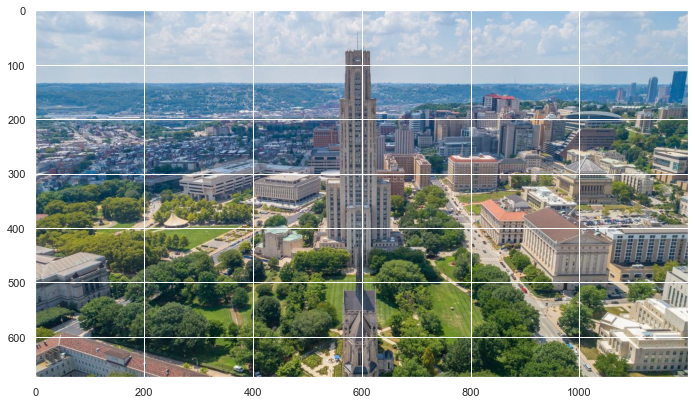

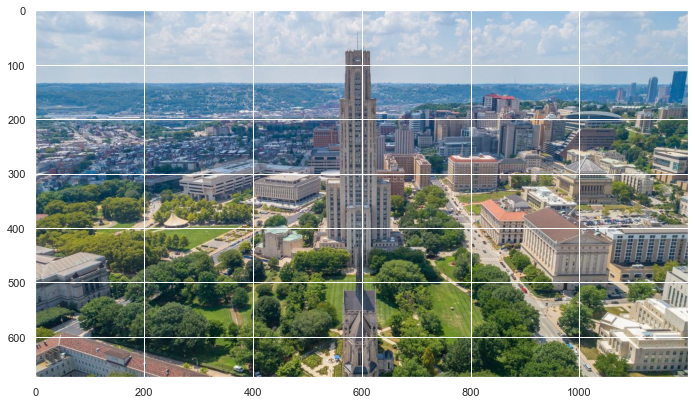

Hail to Pitt!


In [50]:
data = "Hail to Pitt!"
input_img = "original.png"
output_img = "hidden.png"
encode(input_img, data, output_img)

plt.imshow(plt.imread(input_img))
plt.show()
plt.imshow(plt.imread(output_img))
plt.show()

secret = decode(output_img)
print(secret)

### Reference
1. [Steganography](https://www.geeksforgeeks.org/image-based-steganography-using-python/)